In [1]:
import pandas as pd
import seaborn as sns
import os
import glob
import tqdm
import matplotlib.pyplot as plt

In [2]:
sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1.5)

In [3]:
# path = 'realhuman_allframe_1024x576.xlsx'
# path = 'vm108_val_midtri_1024x576_skipsmoke.xlsx'
path = 'vm108_val_midtri_1024x576.xlsx'
# path = 'vm108_val_midtri_256.xlsx'
df = pd.read_excel(path, sheet_name=None)['avg_clip']
df = df.rename(columns={df.columns[0]: 'metric'})
df.index = df['metric']

In [4]:
models = df.columns[1:].tolist()
f = lambda x: x[:-2] + [x[-1], x[-2]]
models = ['_'.join(f(m.split('_'))) if 'width' in m and 'mem' in m else m for m in models]
names, frames = zip(*[(k.rsplit('_mem', maxsplit=1)) for k in models if '_mem' in k and k[-1]=='f'])
names = list(set(names))
frames = sorted([int(i[:-1]) for i in list(set(frames)) if i[:-1].isdigit()])
frames

[1, 30, 60, 120, 240, 480]

In [5]:
# TODO: select some models only
names = [i for i in names if 'replace-tri' not in i]
names

['STCNFuseMatting_fullres_matnaive_seg2_480_temp_seg_allclass',
 'STCNFuseMatting_fullres_matnaive_backbonefuse',
 'STCNFuseMatting_fullres_matnaive_width11',
 'STCNFuseMatting_fullres_matnaive_width41',
 'ft_TCVOM_GCA_TAM',
 'STCNFuseMatting_fullres_matnaive_480_temp_seg',
 'STCNFuseMatting_SingleDec',
 'TCVOM_ft_GCA_TAM_bidir',
 'GFM_GatedFuseVM_2dtv_tempcons_weightce_512',
 'STCNFuseMatting_SameDec_480',
 'TCVOM_GCA_TAM',
 'STCNFuseMatting_fullres_matnaive',
 'TCVOM_GCA_TAM_bidir',
 'GFM_GatedFuseVM_3dtvloss_weightce_512',
 'STCNFuseMatting_fullres_480_none_temp_seg',
 'STCNFuseMatting_fullres_matnaive_naivefuse',
 'STCNFuseMatting_fuse=naive_480',
 'STCNFuseMatting_fullres_matnaive_width81',
 'GFM_GatedFuseVM_3dtvloss_480',
 'STCNFuseMatting_fullres_480_temp_seg_allclass_weight_x1',
 'STCNFuseMatting_fullres_matnaive_none_temp_seg']

In [6]:
metric_dfs = {}
avg_dfs = {}
for model in names:
    # print(model+"_mem30f" in df.columns)
    if 'width' in model:
        func = lambda m, f: '_'.join(m[:-1] + [f'mem{f}f', m[-1]])
        cols = [(f'{f}', col) for f in frames if (col:=func(model.split('_'), f)) in df.columns]
        # print(col)
    else:
        cols = [(f'{f}', col) for f in frames if (col:=f'{model}_mem{f}f') in df.columns]
    if model == 'TCVOM_GCA_TAM_bidir':
        cols.append(('first only', 'TCVOM_GCA_TAM'))
        cols.append(('1', 'TCVOM_GCA_TAM_mem1f'))
    elif model == 'TCVOM_ft_GCA_TAM_bidir':
        cols.append(('first only', 'ft_TCVOM_GCA_TAM'))
        cols.append(('1', 'TCVOM_GCA_TAM_mem1f'))
    else:
        cols.append(('first only', model))
    # print(cols)
    idx, cols = zip(*cols)
    model_df = df[list(cols)]
    model_df.columns = idx
    avg_dfs[model] = model_df
metric = model_df.index

In [19]:
name_dict = {
    # 'GFM_GatedFuseVM_4xfoucs': 'Fixed dilation width',
    # 'GFM_GatedFuseVM_4xfoucs_randmemtrimap': 'Smaller dilation width',
    # 'GFM_GatedFuseVM_3dtvloss_480': 'GFM_GatedFuseVM_3dtvloss_480',
    # 'GFM_GatedFuseVM_3dtvloss_weightce_512': 'GFM_GatedFuseVM_3dtvloss_weightce_512',
    # 'GFM_GatedFuseVM_2dtv_tempcons_weightce_512': 'GFM_GatedFuseVM_2dtv_tempcons_weightce_512',
    'STCNFuseMatting_fullres_matnaive_width11': '$k=11$',
    'STCNFuseMatting_fullres_matnaive': '$k=25$',
    'STCNFuseMatting_fullres_matnaive_width41': '$k=41$',
    'STCNFuseMatting_fullres_matnaive_width81': '$k=81$',
    # 'STCNFuseMatting_fullres_480_temp_seg_allclass_weight_x1': 'STCNFM TempAllClassWeightx1',
    # 'STCNFuseMatting_fullres_matnaive_480_temp_seg': 'STCNFM TempCorrectClass',
    # 'STCNFuseMatting_fullres_matnaive_seg2_480_temp_seg_allclass': 'STCNFM TempAllClass',
    # 'STCNFuseMatting_fullres_matnaive_none_temp_seg': 'STCNFM NoneTemp',
    # 'STCNFuseMatting_SingleDec': 'SingleDec',
    # 'STCNFuseMatting_SameDec_480': 'SameDec',
    # 'STCNFuseMatting_fullres_matnaive_backbonefuse': 'Backbonefuse',
    # 'STCNFuseMatting_fullres_matnaive_naivefuse': 'Naivefuse',
    # 'TCVOM_GCA_TAM_bidir': 'STM + TCVOM',
    # 'TCVOM_GCA_TAM': 'TCVOM',
    # 'ft_TCVOM_GCA_TAM': 'TCVOM Finetune',
    # 'TCVOM_ft_GCA_TAM_bidir': 'STM(ft) + TCVOM',
    # 'STCNFuseMatting_fullres_matnaive': 'FTP-VM (Ours)',
}

In [8]:
def sort_time(df):
    time_order = [f'{f}' for f in frames] + ['first only']
    return df.reindex(time_order)

In [20]:
metric_names = {
    'mad': 'MAD',
    'mse': 'MSE',
    'dtssd': 'dtSSD',
    'conn': 'Conn',
    'grad': 'Grad',
    'sad': 'SAD',
}
def metric_name(metric):
    for k in metric_names:
        if k in metric.split('_')[-1]:
            return metric_names[k]
    return 'not_found'

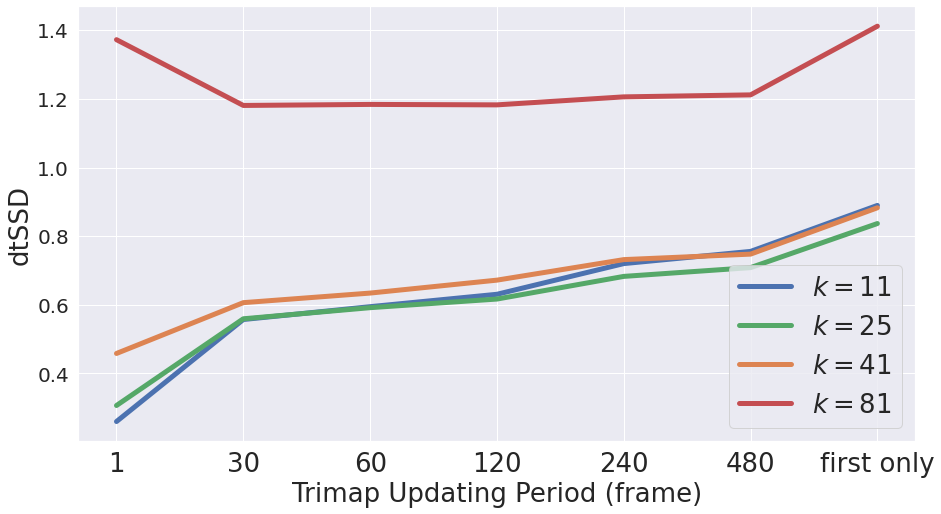

In [23]:
def run_fig(avg_dfs, name_dict, metric, save_path=''):
    # for metric in avg_dfs[next(iter(avg_dfs))]
    # df = pd.DataFrame({k: v.loc[metric] for k, v in avg_dfs.items()})
    df = pd.DataFrame({name_dict[k]: v.loc[metric] for k, v in avg_dfs.items() if k in name_dict})
    # df = pd.DataFrame({name_dict[k]: v[metric] for k, v in avg_dfs.items()})
    df = sort_time(df)
    # plt.figure()
    plt.clf()
    lp = sns.lineplot(data=df, linewidth=5, dashes=False)
    lp.set_xlabel("Trimap Updating Period (frame)", fontsize = 26)
    lp.set_ylabel(metric_name(metric), fontsize = 26)
    plt.tick_params(axis='x', which='major', labelsize=26)
    plt.tick_params(axis='y', which='major', labelsize=20)
    # lp.set(title=f'{metric}')
    # lp.set(ylim=(15, 35))
    d = {l:h for h, l in zip(*lp.get_legend_handles_labels())}
    h, l = zip(*[(d[k], k) for k in name_dict.values()])
    for leg in lp.legend(h, l, fontsize='26').get_lines():
        leg.set_linewidth(5)
    if save_path != '':
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, metric+".png"), bbox_inches='tight')
# metric = 'pha_grad'
# run_fig(avg_dfs, name_dict, 'pha_dtssd')
for metric in avg_dfs[next(iter(avg_dfs))].index:
    run_fig(avg_dfs, name_dict, metric, 'figs_mem_vs_TCVOM')
    # break

In [22]:
def plot_hist(score):
    df = score.melt(value_vars=score.columns).dropna()
    sns.displot(data=df, col='variable', x='value', multiple='dodge', bins=10)
    sns.set(rc={'figure.figsize':(8, 8)})
    # sns.set_context(
    #     # "notebook", 
    #     font_scale=2, 
    #     rc={"lines.linewidth": 2, 'figure.figsize':(26,18)}
    # )
df = pd.DataFrame({
    'TCVOM': metric_dfs['TCVOM_GCA_TAM']['pha_dtssd']['mem30f'],
    'GFM GatedFuseVM(TempCons)': metric_dfs['GFM_GatedFuseVM_temp_cons']['pha_dtssd']['mem30f']
})
plot_hist(df)

KeyError: 'TCVOM_GCA_TAM'

In [ ]:
lp = sns.lineplot(data=df, linewidth=5)
for leg in lp.legend().get_lines():
    leg.set_linewidth(5)